# Analyzing KDF Robustness to Label Noise

This tutorial seeks to expand on `bayeserrorestimate_gaussianparity.ipynb` by exploring a property of the Kerenel Density Forest (KDF). Here, the goal is to explore robustness to contamination in the Gaussian XOR distribution compared to the Random Forest (RF) algorithm. 

Recall from `bayeserrorestimate_gaussianparity.ipynb` that the **estimated Bayes Error is 0.267.**

In [1]:
# Created by: Jacob Desman
# Date: 2021-11-22
# Contact at: jake.m.desman@gmail.com

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from kdg import kdf
from sklearn.ensemble import RandomForestClassifier as rf
from kdg.utils import generate_gaussian_parity
from functions.kdf_gaussian_xor_label_noise import plot_gaussians
from functions.kdf_gaussian_xor_label_noise import label_noise_trial

## Distributions of Interest
As an example, we show the Guassian parity problem of interest below. The left figure shows the original distribution while the right figure illustrates 20% contamination in the labels.

Text(0.5, 1.0, '20% Flipped Labels')

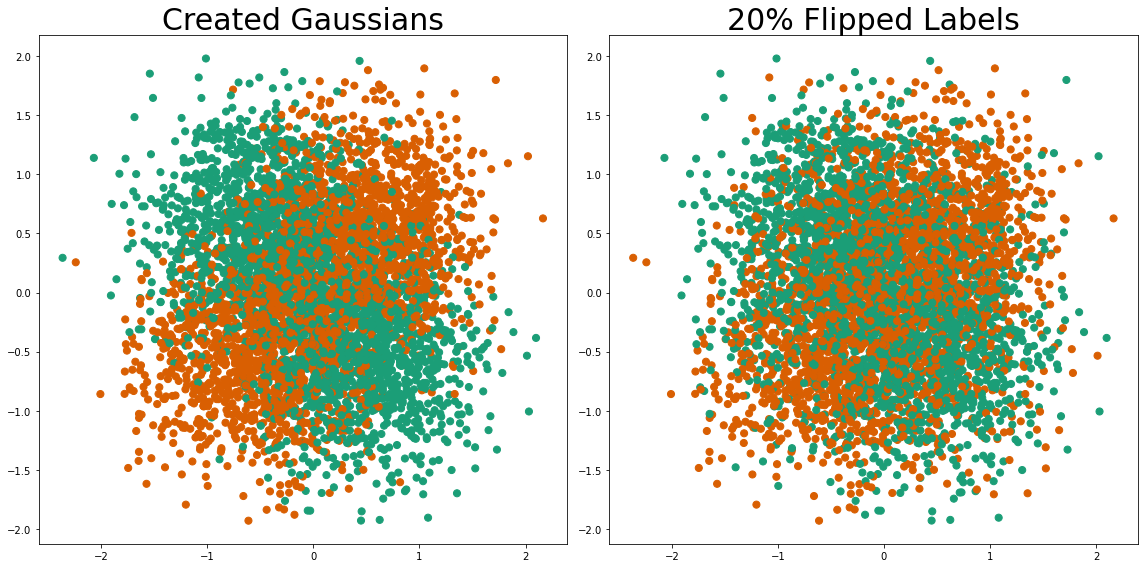

In [3]:
# Show the sample blobs / Gaussians
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
n_samples = 5000

# Generate original distribution
X, y = generate_gaussian_parity(n_samples, cluster_std=0.5)
plot_gaussians(X, y, ax=ax[0])
plt.gca().set_title('Uncontaminated Labels', fontsize=30)

# Randomly flip labels
p = 0.20
n_noise = np.int32(np.round(len(X) * p))
noise_indices = random.sample(range(len(X)), n_noise)
y[noise_indices] = 1 - y[noise_indices]
plot_gaussians(X, y, ax=ax[1])
plt.gca().set_title('20% Flipped Labels', fontsize=30)

## Experiment: Accuracy in Contaminated Environment
This will compare the error rate of the Kernel Density Forest algorithm to the Random Forest algorithm at different label contamination levels: 0%, 10%, 20%, 30%, and 40%. Multiple trials will be conducted at each contamination level.

In [ ]:
df = pd.DataFrame()
reps = 10
n_estimators = 500
n_samples = 5000

err_kdf = []
err_rf = []
proportions = [0.0, 0.1, 0.2, 0.3, 0.4]
proportion_list = []
reps_list = []

for p in proportions:
    for ii in range(reps):
        err_kdf_i, err_rf_i = label_noise_trial(
            n_samples=n_samples, p=p, n_estimators=n_estimators
        )
        err_kdf.append(err_kdf_i)
        err_rf.append(err_rf_i)
        reps_list.append(ii)
        proportion_list.append(p)

# Construct DataFrame
df["reps"] = reps_list
df["proportion"] = proportion_list
df["error_kdf"] = err_kdf
df["error_rf"] = err_rf

err_kdf_med = []
err_kdf_25_quantile = []
err_kdf_75_quantile = []
err_rf_med = []
err_rf_25_quantile = []
err_rf_75_quantile = []

for p in proportions:
    curr_kdf = df["error_kdf"][df["proportion"] == p]
    curr_rf = df["error_rf"][df["proportion"] == p]

    err_kdf_med.append(np.median(curr_kdf))
    err_kdf_25_quantile.append(np.quantile(curr_kdf, [0.25])[0])
    err_kdf_75_quantile.append(np.quantile(curr_kdf, [0.75])[0])

    err_rf_med.append(np.median(curr_rf))
    err_rf_25_quantile.append(np.quantile(curr_rf, [0.25])[0])
    err_rf_75_quantile.append(np.quantile(curr_rf, [0.75])[0])

# Plotting
sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(proportions, err_kdf_med, c="r", label="KDF-ET")
ax.fill_between(
    proportions, err_kdf_25_quantile, err_kdf_75_quantile, facecolor="r", alpha=0.3
)
ax.plot(proportions, err_rf_med, c="k", label="ET")
ax.fill_between(
    proportions, err_rf_25_quantile, err_rf_75_quantile, facecolor="k", alpha=0.3
)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_xlabel("Label Noise Proportion")
ax.set_ylabel("Error")
plt.title("Gaussian Parity Label Noise")
ax.legend(frameon=False)
plt.show()